# Establishing VR model for TAN prediction

Lab-scale AD\
System: SBR\
Working Vol.: 270 mL\
Substrate: fish waste powder\
No. of features: 32\
N train: 259\
N test: 65

In [1]:
#Import data
import numpy as np
import pandas as pd
mydata = 'ML_Startup1_210331.xlsx'
cols = 'C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,W'
colnames = ['Duplicate', 'Start/End', 'Cycle_No', 'Feeding', 'TS', 'VS', 'VSS', 'COD', 'sCOD', 'Protein', 'Lipid', 'TAN', 'CH4_yield', 'Acetate', 
            'Propionate', 'i-Butyrate', 'n-Butyrate', 'i-Valerate', 'n-Valerate', 'n-Caproate']
dataimport1 = pd.read_excel(mydata, sheet_name='7d', header=None, names=colnames, usecols=cols, skiprows=2, na_values=['',' - ',0])
dataimport1['dtime'] = '7d'
dataimport2 = pd.read_excel(mydata, sheet_name='9d', header=None, names=colnames, usecols=cols, skiprows=2, na_values=['',' - ',0])
dataimport2['dtime'] = '9d'
dataimport3 = pd.read_excel(mydata, sheet_name='13d', header=None, names=colnames, usecols=cols, skiprows=2, na_values=['',' - ',0])
dataimport3['dtime'] = '13d'
alldata = pd.concat([dataimport1, dataimport2, dataimport3])
alldata.dropna(how = 'all', inplace=True)
datafinal = alldata.fillna(0)

In [2]:
#Encode Start/End col
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
datafinal['Start/End_le'] = le.fit_transform(datafinal['Start/End'])
datafinal['Start/End_le'] = datafinal['Start/End_le'].astype('int')
assert datafinal['Start/End_le'].dtype == 'int'
dataok = datafinal.drop('Start/End', axis=1)

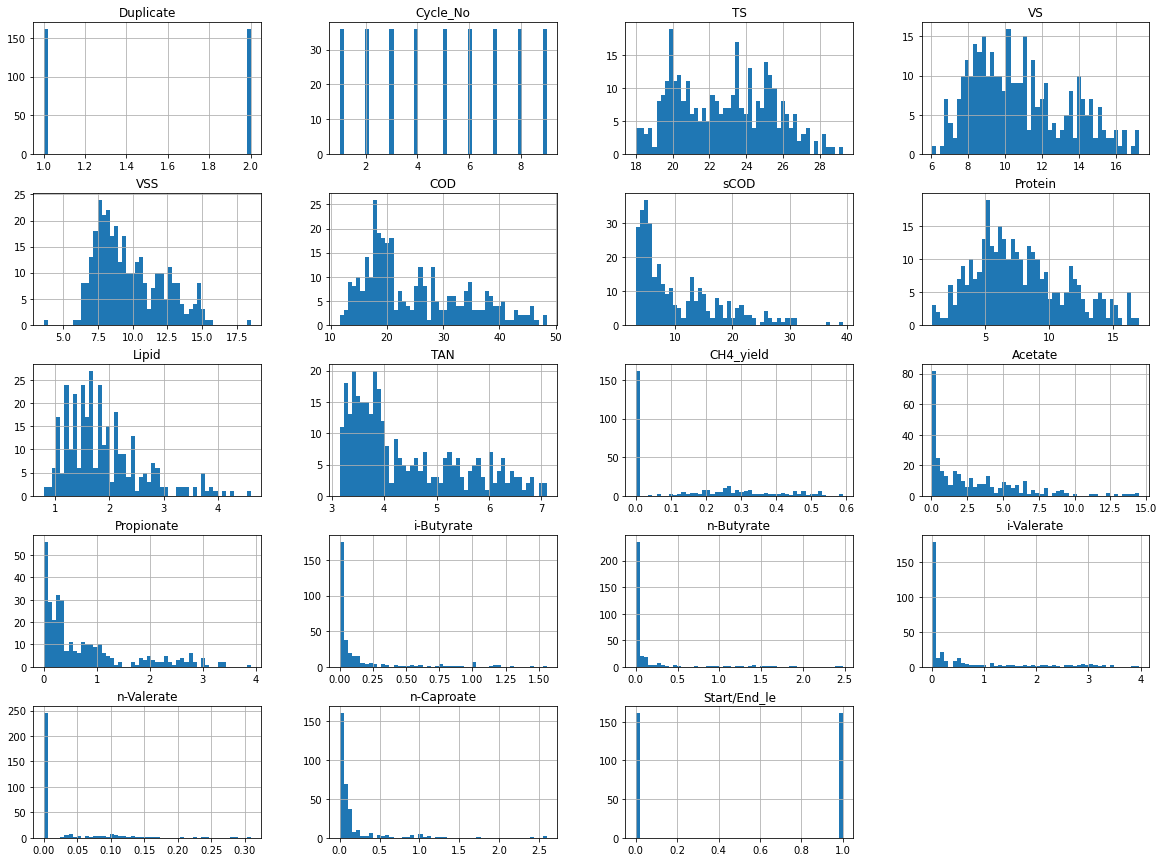

<Figure size 432x288 with 0 Axes>

In [3]:
#Visualizing raw data
import matplotlib.pyplot as plt
import seaborn as sns
dataok.hist(bins=50, figsize=(20,15))
plt.show()
plt.clf()

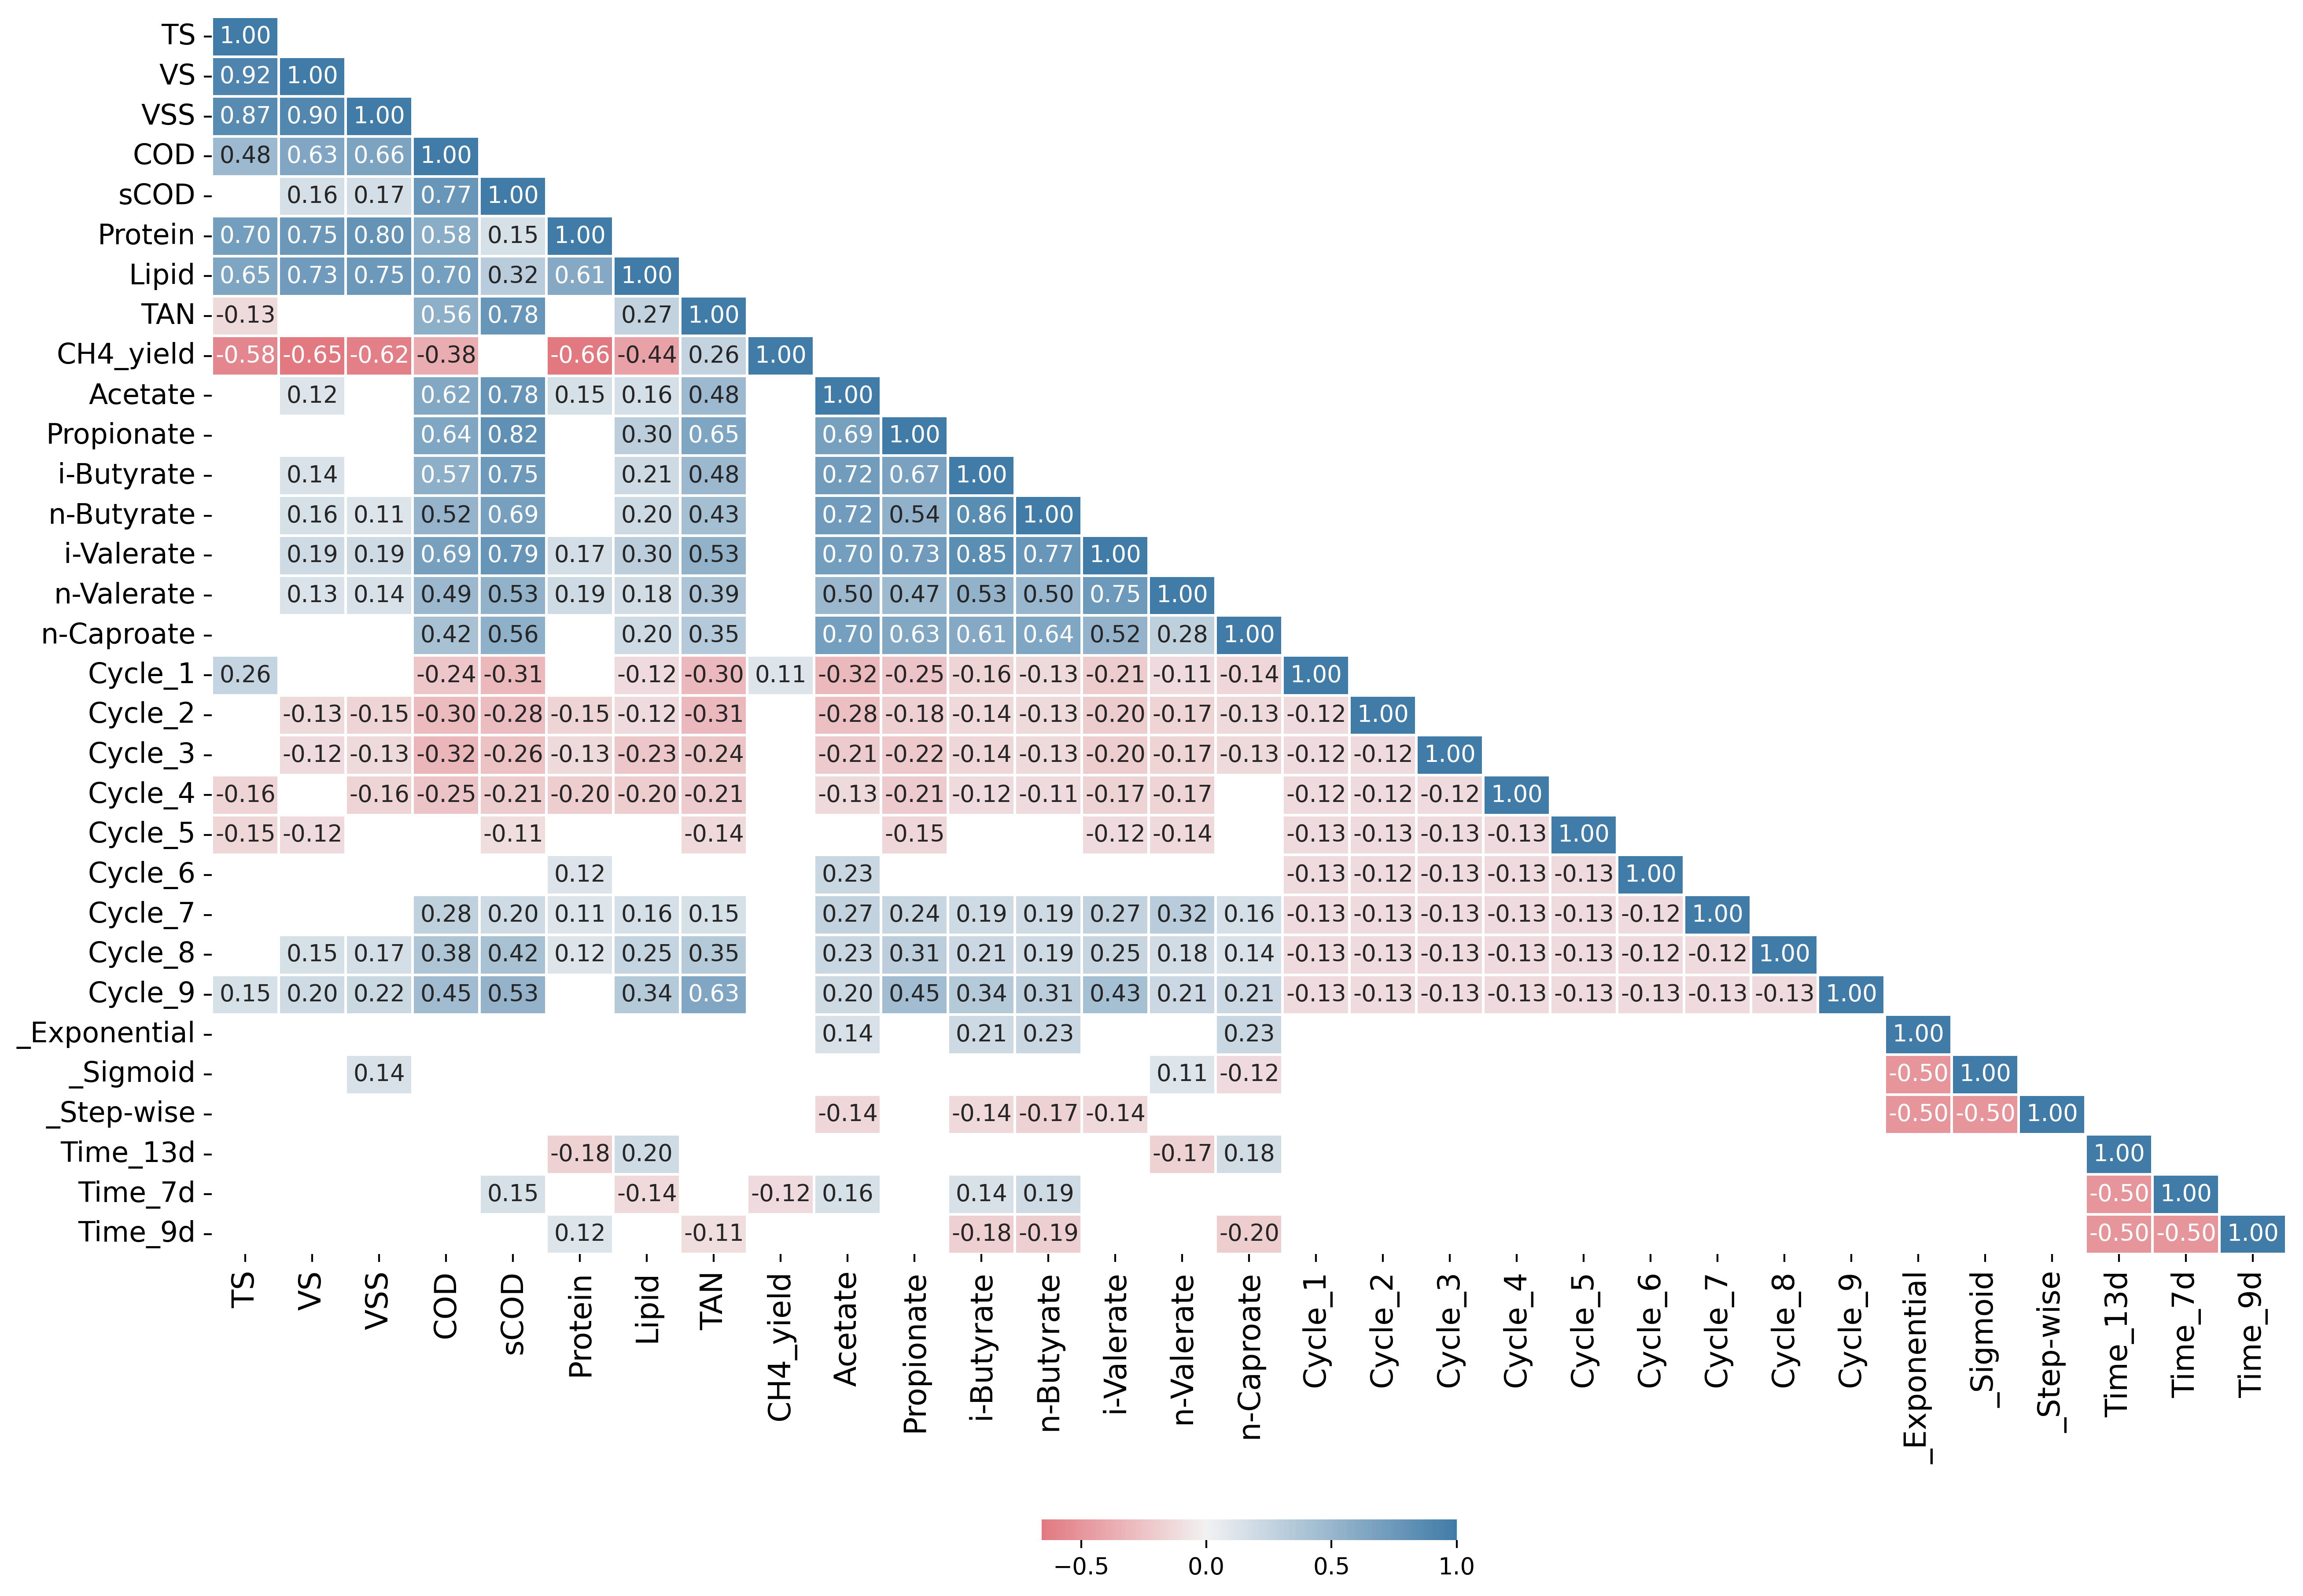

In [4]:
#Visualize correlation matrix
from scipy import stats
data_ohe = pd.get_dummies(dataok, columns=['Cycle_No', 'Feeding', 'dtime'], prefix=['Cycle', '', 'Time'])
hmdata = data_ohe.drop(['Duplicate', 'Start/End_le'], axis=1)
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(16,14), dpi=380)
    cmap = sns.diverging_palette(h_neg=10, h_pos=240,as_cmap=True)
    sns.heatmap(corr, ax=ax, mask=mask, center=0, cmap=cmap, linewidths=0.8, annot=True, fmt='.2f', cbar=True, 
                cbar_kws={'shrink':0.2, 'location':'bottom'})
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=13)

corr = hmdata.corr()
p_values = corr_sig(hmdata)
mask = np.invert(np.tril(p_values<=0.05), dtype=bool)
plot_cor_matrix(corr, mask=mask)
plt.show()

In [5]:
#Define features and target
X = dataok.drop('TAN', axis = 1)
y = dataok[['TAN']].values.ravel()

In [6]:
#One hot encoding
X_ohe = pd.get_dummies(X, columns=['Cycle_No', 'Feeding', 'dtime'], prefix=['Cycle', '', 'Time'])

In [7]:
#Split train and test data
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_ohe,y,test_size=0.2, random_state=42)

In [8]:
#Scaling the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_trainscaled = sc.fit_transform(X_train)
X_testscaled = sc.transform(X_test)

In [9]:
#Preliminary model
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as MSE
SVRm = SVR()
NuSVRm = NuSVR()
LinSVRm = LinearSVR()
LinRegm = LinearRegression()
Lassom = Lasso()
Ridgem = Ridge()
ENm = ElasticNet()
DTm = DecisionTreeRegressor()
KNNm = KNeighborsRegressor()

In [10]:
#Hyperparameter tuning
#SVR_grid = {'C': [0.5,1,10,100], 'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
#op_SVR = GridSearchCV(SVRm, SVR_grid, cv=5, scoring='neg_mean_squared_error')
#op_SVR.fit(X_trainscaled, y_train)
#print('\nBest params of SVR model: {}'.format(op_SVR.best_params_))

#NuSVR_grid = {'nu': np.arange(0.1,1,0.1), 'C': np.arange(1,100,5),'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
#op_NuSVR = GridSearchCV(NuSVRm, NuSVR_grid, cv=5, scoring='neg_mean_squared_error')
#op_NuSVR.fit(X_trainscaled, y_train)
#print('\nBest params of NuSVR model: {}'.format(op_NuSVR.best_params_))

#LinSVR_grid = {'epsilon': np.arange(0,10,0.1), 'C': np.arange(0.1,100,5), 'max_iter': (30000,100000,10000), 'random_state': [123]}
#op_LinSVR = GridSearchCV(LinSVRm, LinSVR_grid, cv=5, scoring='neg_mean_squared_error')
#op_LinSVR.fit(X_trainscaled, y_train)
#print('\nBest params of LinSVR model: {}'.format(op_LinSVR.best_params_)) #grid twice

#Lasso_grid = {'alpha': np.arange(0,0.1,0.01), 'max_iter': np.arange(10000,100000,10000), 'normalize': ['False', 'True'], 'random_state':[123]}
#op_Lasso = GridSearchCV(Lassom, Lasso_grid, cv=5, scoring='neg_mean_squared_error')
#op_Lasso.fit(X_trainscaled, y_train)
#print('\nBest params of Lasso model: {}'.format(op_Lasso.best_params_)) #grid twice

#Ridge_grid = {'alpha': np.arange(0,0.1,0.01), 'normalize': ['False','True'], 'random_state': [123]}
#op_Ridge = GridSearchCV(Ridgem, Ridge_grid, cv=5, scoring='neg_mean_squared_error')
#op_Ridge.fit(X_trainscaled, y_train)
#print('\nBest params of Ridge model: {}'.format(op_Ridge.best_params_))

#EN_grid = {'alpha': np.arange(0,1,0.01), 'max_iter': np.arange(10000,100000,10000), 'l1_ratio': np.arange(0.1,1,0.1), 'random_state':[123]}
#op_EN = GridSearchCV(ENm, EN_grid, cv=5, scoring='neg_mean_squared_error')
#op_EN.fit(X_trainscaled, y_train)
#print('\nBest params of Elastic Net model: {}'.format(op_EN.best_params_)) #grid twice

#DT_grid = {'max_depth': np.arange(2,15,1), 'max_features': np.arange(0.3,1,0.1), 'random_state':[123]}
#op_DT = GridSearchCV(DTm, DT_grid, cv=5, scoring='neg_mean_squared_error')
#op_DT.fit(X_trainscaled, y_train)
#print('\nBest params of Decision Tree model: {}'.format(op_DT.best_params_))

#KNN_grid = {'n_neighbors':np.arange(1,10,1), 'weights': ['uniform','distance'], 'p': [1,2]}
#op_KNN = GridSearchCV(KNNm, KNN_grid, cv=5, scoring='neg_mean_squared_error')
#op_KNN.fit(X_trainscaled, y_train)
#print('\nBest params of KNN model: {}'.format(op_KNN.best_params_))

In [11]:
#Refitting
SVRbest = SVR(C=100, gamma=0.01, kernel='rbf')
NuSVRbest = NuSVR(nu=0.1, C=51, gamma=0.01, kernel='rbf')
LinSVRbest = LinearSVR(C=75.1, epsilon=0.2, max_iter=10000, random_state=123)
Lassobest = Lasso(alpha=0, max_iter=10000, normalize=False, random_state=123)
Ridgebest = Ridge(alpha=0.01, normalize=False, random_state=123)
ENbest = ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=10000, random_state=123)
DTbest = DecisionTreeRegressor(max_depth=12, max_features=0.8000000000000003, random_state=123)
KNNbest = KNeighborsRegressor(n_neighbors=1, weights='uniform', p=2)

In [13]:
#Meta-models
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, BaggingRegressor
rf = RandomForestRegressor()
#rf_grid = {'n_estimators': np.arange(50,300,50), 'max_depth': np.arange(3,15,1), 'min_samples_leaf': np.arange(1,200,10), 'max_features': np.arange(0.3,1,0.1), 'n_jobs': [-1], 'oob_score': [True]}
#op_rf = GridSearchCV(rf, rf_grid, cv=5, scoring='neg_mean_squared_error')
#op_rf.fit(X_trainscaled, y_train)
#print('\nBest params of Random Forest model: {}'.format(op_rf.best_params_)) #takes time

In [14]:
rfbest = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=1, max_features=0.5, n_jobs=-1, 
                               oob_score=True, random_state=123)
regressors2 = [('SVR', SVRbest), ('NuSVR', NuSVRbest), ('Ridge', Ridgebest), ('KNN', KNNbest)]

In [17]:
#Model evaluation
def get_models():
    '''Get models to evaluate'''
    models = dict()
    models['SVR-pre'] = SVRm
    models['NuSVR-pre'] = NuSVRm
    models['LinearSVR-pre'] = LinSVRm
    models['LinearRegression'] = LinRegm
    models['Lasso-pre'] = Lassom
    models['Ridge-pre'] = Ridgem
    models['ElasticNet-pre'] = ENm
    models['DecisionTree-pre'] = DTm
    models['KNN-pre'] = KNNm
    models['SVR-tuned'] = SVRbest
    models['NuSVR-tuned'] = NuSVRbest
    models['LinearSVR-tuned'] = LinSVRbest
    models['Lasso-tuned'] = Lassobest
    models['Ridge-tuned'] = Ridgebest
    models['ElasticNet-tuned'] = ENbest
    models['DecisionTree-tuned'] = DTbest
    models['KNN-tuned'] = KNNbest
    models['Voting regressor'] = VotingRegressor(estimators=regressors2)
    models['Random Forest'] = rfbest
    return models

def eval_model():
    model.fit(X_trainscaled, y_train)
    cv = np.abs(cross_val_score(model, X_trainscaled, y_train, cv=5, scoring='neg_root_mean_squared_error'))
    return cv

In [18]:
models = get_models()
results, names = list(), list()
R2_train, names = list(), list()
R2_test, names = list(), list()
for name, model in models.items():
    cvscores = eval_model()
    results.append(cvscores)
    R2_train.append(model.score(X_trainscaled, y_train))
    R2_test.append(model.score(X_testscaled, y_test))
    names.append(name)
    y_pred_train = model.predict(X_trainscaled)
    y_pred_test = model.predict(X_testscaled)
    print('R^2 train of {:s}: {:.3f}'.format(name, model.score(X_trainscaled, y_train)))
    print('R^2 test of {:s}: {:.3f}'.format(name, model.score(X_testscaled, y_test)))
    print('Average RMSE-CV of %s: %.3f (%.3f)' % (name, np.mean(cvscores), np.std(cvscores)))
    print('RMSE-train of {:s}: {:.3f}'.format(name, np.sqrt(np.abs(MSE(y_train, y_pred_train)))))
    print('RMSE-test of {:s}: {:.3f}\n'.format(name, np.sqrt(np.abs(MSE(y_test, y_pred_test)))))

R^2 train of SVR-pre: 0.977
R^2 test of SVR-pre: 0.920
Average RMSE-CV of SVR-pre: 0.342 (0.111)
RMSE-train of SVR-pre: 0.161
RMSE-test of SVR-pre: 0.289

R^2 train of NuSVR-pre: 0.979
R^2 test of NuSVR-pre: 0.919
Average RMSE-CV of NuSVR-pre: 0.334 (0.114)
RMSE-train of NuSVR-pre: 0.154
RMSE-test of NuSVR-pre: 0.290

R^2 train of LinearSVR-pre: 0.872
R^2 test of LinearSVR-pre: 0.927
Average RMSE-CV of LinearSVR-pre: 0.392 (0.102)
RMSE-train of LinearSVR-pre: 0.379
RMSE-test of LinearSVR-pre: 0.276

R^2 train of LinearRegression: 0.908
R^2 test of LinearRegression: 0.915
Average RMSE-CV of LinearRegression: 0.366 (0.074)
RMSE-train of LinearRegression: 0.322
RMSE-test of LinearRegression: 0.298

R^2 train of Lasso-pre: 0.000
R^2 test of Lasso-pre: -0.000
Average RMSE-CV of Lasso-pre: 1.069 (0.062)
RMSE-train of Lasso-pre: 1.061
RMSE-test of Lasso-pre: 1.021

R^2 train of Ridge-pre: 0.907
R^2 test of Ridge-pre: 0.914
Average RMSE-CV of Ridge-pre: 0.363 (0.077)
RMSE-train of Ridge-pre: 0

C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc

R^2 train of KNN-pre: 0.936
R^2 test of KNN-pre: 0.905
Average RMSE-CV of KNN-pre: 0.418 (0.090)
RMSE-train of KNN-pre: 0.269
RMSE-test of KNN-pre: 0.314

R^2 train of SVR-tuned: 0.994
R^2 test of SVR-tuned: 0.973
Average RMSE-CV of SVR-tuned: 0.268 (0.049)
RMSE-train of SVR-tuned: 0.084
RMSE-test of SVR-tuned: 0.169

R^2 train of NuSVR-tuned: 0.998
R^2 test of NuSVR-tuned: 0.976
Average RMSE-CV of NuSVR-tuned: 0.255 (0.047)
RMSE-train of NuSVR-tuned: 0.048
RMSE-test of NuSVR-tuned: 0.158



C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc

R^2 train of LinearSVR-tuned: 0.883
R^2 test of LinearSVR-tuned: 0.914
Average RMSE-CV of LinearSVR-tuned: 0.369 (0.106)
RMSE-train of LinearSVR-tuned: 0.362
RMSE-test of LinearSVR-tuned: 0.299



C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.457633540263192, tolerance: 0.029146579522532818
  model = cd_fast.enet_coordinate_descent(
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Arma Yulisa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number o

R^2 train of Lasso-tuned: 0.908
R^2 test of Lasso-tuned: 0.915
Average RMSE-CV of Lasso-tuned: 0.366 (0.074)
RMSE-train of Lasso-tuned: 0.322
RMSE-test of Lasso-tuned: 0.298

R^2 train of Ridge-tuned: 0.908
R^2 test of Ridge-tuned: 0.915
Average RMSE-CV of Ridge-tuned: 0.366 (0.075)
RMSE-train of Ridge-tuned: 0.322
RMSE-test of Ridge-tuned: 0.298

R^2 train of ElasticNet-tuned: 0.906
R^2 test of ElasticNet-tuned: 0.911
Average RMSE-CV of ElasticNet-tuned: 0.362 (0.082)
RMSE-train of ElasticNet-tuned: 0.325
RMSE-test of ElasticNet-tuned: 0.304

R^2 train of DecisionTree-tuned: 1.000
R^2 test of DecisionTree-tuned: 0.799
Average RMSE-CV of DecisionTree-tuned: 0.559 (0.104)
RMSE-train of DecisionTree-tuned: 0.014
RMSE-test of DecisionTree-tuned: 0.457

R^2 train of KNN-tuned: 1.000
R^2 test of KNN-tuned: 0.955
Average RMSE-CV of KNN-tuned: 0.314 (0.052)
RMSE-train of KNN-tuned: 0.000
RMSE-test of KNN-tuned: 0.216

R^2 train of Voting regressor: 0.991
R^2 test of Voting regressor: 0.976
Av

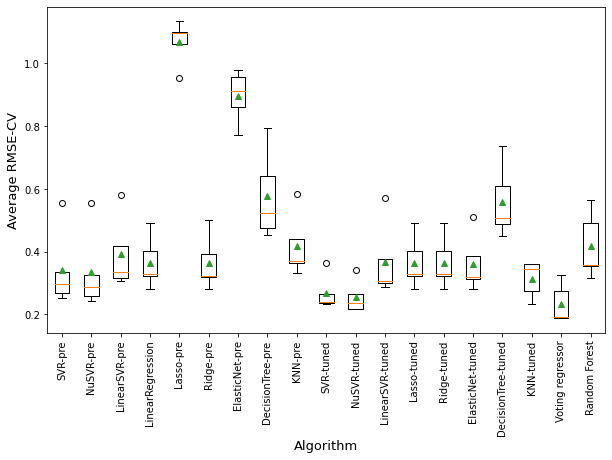

In [20]:
#Comparing RMSE-cross-validation of all train-models (only for machine learning)
plt.figure(figsize=(10,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=90)
hfont = {'fontname': 'sans-serif'}
plt.ylabel('Average RMSE-CV', fontsize=13)
plt.xlabel('Algorithm', fontsize=13, **hfont)
plt.show()

In [22]:
#Ensemble prediction for visualization
vr2 = VotingRegressor(estimators=regressors2)
vr2.fit(X_trainscaled, y_train)
y_predvr2 = vr2.predict(X_testscaled)

rfbest.fit(X_trainscaled, y_train)
rfpred_test = rfbest.predict(X_testscaled)


95% CI of rmse-test of selected model (VR2):  [0.10449066 0.19644854]


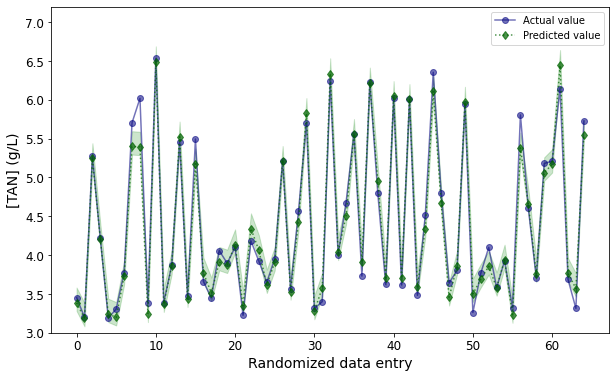

In [23]:
#95% CI
from scipy import stats
confidence = 0.95
squared_errors = (y_predvr2 - y_test) ** 2
CI = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print('\n95% CI of rmse-test of selected model (VR2): ', CI)

#Visualize actual vs. predicted values
cilow = 0.10449066
cihigh = 0.19644854
x = np.arange(0,65)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y_test, marker='o', c='navy', label="Actual value", alpha=0.55, scalex=True)
ax.plot(x, y_predvr2, marker='d', c='darkgreen', label="Predicted value", alpha=0.7, linestyle='dotted', scalex=True)
ax.legend()
ax.set_xlabel("Randomized data entry", fontsize=14)
ax.set_ylabel("[TAN] (g/L)", fontsize=14)
plt.fill_between(x, (y_predvr2-cilow), (y_predvr2+cihigh), color='green', alpha=0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(3, 7.2)
plt.show()

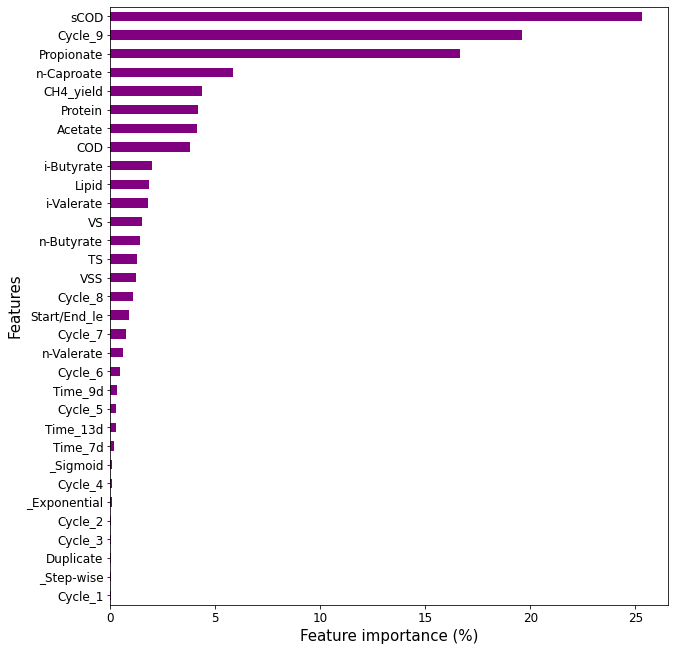

In [24]:
#Feature importance
xrf2 = pd.Series(rfbest.feature_importances_ * 100, index=X_ohe.columns)
sortedxrf2 = xrf2.sort_values()
plt.figure(figsize=(10,11))
sortedxrf2.plot(kind='barh', color='purple')
plt.ylabel('Features', fontsize=15)
plt.xlabel('Feature importance (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# Example of using VR in another AD system

Full-scale AD\
System: CSTR\
Working Vol.: 3,500 m3\
Substrate: Sludge + food waste\
No. of features: 11\
N train: 160\
N test: 54

In [32]:
VR_test = 'VR_test.xlsx'
cols_as = 'A,B,C,D,E,F,G,H,I,J,K,L'
colnames_as = ['pH','Alk','COD','SCOD','Ace','Prop','TS','VS','TC','Prot','Lipid','TAN']
data_as = pd.read_excel(VR_test, sheet_name='Ansan', header=None, names=colnames_as, usecols=cols_as, 
                          skiprows=2, na_values=['',' - '])

In [33]:
#Pre-processing
X_as = data_as.drop('TAN', axis = 1)
y_as = data_as[['TAN']].values.ravel()

X_as_train, X_as_test, y_as_train, y_as_test = train_test_split(X_as, y_as, test_size=0.25, random_state=42)

scra = StandardScaler()
X_as_train_sc = scra.fit_transform(X_as_train)
X_as_test_sc = scra.transform(X_as_test)

In [34]:
#Tuning
SVR_grid = {'C': [0.5,1,10,30,60,90], 'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
op_SVR = GridSearchCV(SVRm, SVR_grid, cv=5, scoring='neg_mean_squared_error')
op_SVR.fit(X_as_train_sc, y_as_train)
print('\nBest params of SVR model: {}'.format(op_SVR.best_params_))

NuSVR_grid = {'nu': np.arange(0.1,1,0.1), 'C': np.arange(1,100,5),'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
op_NuSVR = GridSearchCV(NuSVRm, NuSVR_grid, cv=5, scoring='neg_mean_squared_error')
op_NuSVR.fit(X_as_train_sc, y_as_train)
print('\nBest params of NuSVR model: {}'.format(op_NuSVR.best_params_))

Ridge_grid = {'alpha': np.arange(0,0.1,0.01), 'normalize': ['False','True'], 'random_state': [123]}
op_Ridge = GridSearchCV(Ridgem, Ridge_grid, cv=5, scoring='neg_mean_squared_error')
op_Ridge.fit(X_as_train_sc, y_as_train)
print('\nBest params of Ridge model: {}'.format(op_Ridge.best_params_))

KNN_grid = {'n_neighbors':np.arange(1,10,1), 'weights': ['uniform','distance'], 'p': [1,2]}
op_KNN = GridSearchCV(KNNm, KNN_grid, cv=5, scoring='neg_mean_squared_error')
op_KNN.fit(X_as_train_sc, y_as_train)
print('\nBest params of KNN model: {}'.format(op_KNN.best_params_))


Best params of SVR model: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Best params of NuSVR model: {'C': 16, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.4}

Best params of Ridge model: {'alpha': 0.03, 'normalize': 'False', 'random_state': 123}

Best params of KNN model: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


In [35]:
#Refitting
SVRas = SVR(C=10, gamma=0.01, kernel='rbf')
NuSVRas = NuSVR(nu=0.4, C=16, gamma='scale', kernel='rbf')
Ridgeas = Ridge(alpha=0.03, normalize=False, random_state=123)
KNNas = KNeighborsRegressor(n_neighbors=2, weights='distance', p=1)

In [36]:
vras = [('SVR', SVRas), ('NuSVR', NuSVRas), ('Ridge', Ridgeas), ('KNN', KNNas)]

def get_models():
    '''Get models to evaluate'''
    models = dict()
    models['SVR-tuned'] = SVRas
    models['NuSVR-tuned'] = NuSVRas
    models['Ridge-tuned'] = Ridgeas
    models['KNN-tuned'] = KNNas
    models['Voting regressor'] = VotingRegressor(estimators=vras)
    return models

def eval_model():
    model.fit(X_as_train_sc, y_as_train)
    cv = np.abs(cross_val_score(model, X_as_train_sc, y_as_train, cv=5, scoring='neg_root_mean_squared_error'))
    return cv

models = get_models()
results, names = list(), list()
R2_train, names = list(), list()
R2_test, names = list(), list()
for name, model in models.items():
    cvscores = eval_model()
    results.append(cvscores)
    R2_train.append(model.score(X_as_train_sc, y_as_train))
    R2_test.append(model.score(X_as_test_sc, y_as_test))
    names.append(name)
    y_pred_train = model.predict(X_as_train_sc)
    y_pred_test = model.predict(X_as_test_sc)
    print('R^2 train of {:s}: {:.3f}'.format(name, model.score(X_as_train_sc, y_as_train)))
    print('R^2 test of {:s}: {:.3f}'.format(name, model.score(X_as_test_sc, y_as_test)))
    print('Average RMSE-CV of %s: %.3f (%.3f)' % (name, np.mean(cvscores), np.std(cvscores)))
    print('RMSE-train of {:s}: {:.3f}'.format(name, np.sqrt(np.abs(MSE(y_as_train, y_pred_train)))))
    print('RMSE-test of {:s}: {:.3f}\n'.format(name, np.sqrt(np.abs(MSE(y_as_test, y_pred_test)))))

R^2 train of SVR-tuned: 0.839
R^2 test of SVR-tuned: 0.687
Average RMSE-CV of SVR-tuned: 0.077 (0.011)
RMSE-train of SVR-tuned: 0.068
RMSE-test of SVR-tuned: 0.071

R^2 train of NuSVR-tuned: 1.000
R^2 test of NuSVR-tuned: 0.959
Average RMSE-CV of NuSVR-tuned: 0.040 (0.012)
RMSE-train of NuSVR-tuned: 0.000
RMSE-test of NuSVR-tuned: 0.026

R^2 train of Ridge-tuned: 0.828
R^2 test of Ridge-tuned: 0.722
Average RMSE-CV of Ridge-tuned: 0.077 (0.005)
RMSE-train of Ridge-tuned: 0.070
RMSE-test of Ridge-tuned: 0.067

R^2 train of KNN-tuned: 1.000
R^2 test of KNN-tuned: 0.974
Average RMSE-CV of KNN-tuned: 0.033 (0.005)
RMSE-train of KNN-tuned: 0.000
RMSE-test of KNN-tuned: 0.020

R^2 train of Voting regressor: 0.963
R^2 test of Voting regressor: 0.921
Average RMSE-CV of Voting regressor: 0.044 (0.006)
RMSE-train of Voting regressor: 0.032
RMSE-test of Voting regressor: 0.036

